In [1]:
import uproot
import awkward as ak

import matplotlib.pylab as plt
import numpy as np

import time

from hist import Hist


In [2]:
start = time.time()


# At Siena
#filename = '/mnt/qnap/babar_data/test.parquet'
topdir = '/mnt/qnap/babar_data/bnv_plambda'
#filename = f'{topdir}/Background_SP_modes_Only_Run_1.parquet'
filename = f'{topdir}/Background_and_signal_SP_modes_Only_Run_1.parquet'

data = ak.from_parquet(filename)

print(f"Took {time.time() - start} s")


Took 3.140073299407959 s


In [3]:
h = Hist.new.Reg(100, 5.2, 5.3, name="BpostFitMes", label=r"M$_{ES}$ [GeV/c$^2$]") \
         .StrCat([], name="SP", label="SP modes", growth=True)\
         .StrCat([], name="cuts", label="Cuts", growth=True)\
         .Weight()


bkg_spmodes = ['998','1005', '1235', '1237', '991']
spmodes = bkg_spmodes + ['-999']
#spmodes = ['991']

for spmode in spmodes:
    mask = data.spmode == spmode
    x = data[mask]['BpostFitMes'][:,0]

    weight = 1
    if spmode == '-999':
        weight = 0.02
    
    h.fill(BpostFitMes=x, SP=spmode, cuts=f"0", weight=weight)

/home/josieswann/micromamba/envs/pyhep311/lib/python3.11/site-packages/hist/basehist.py:406: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


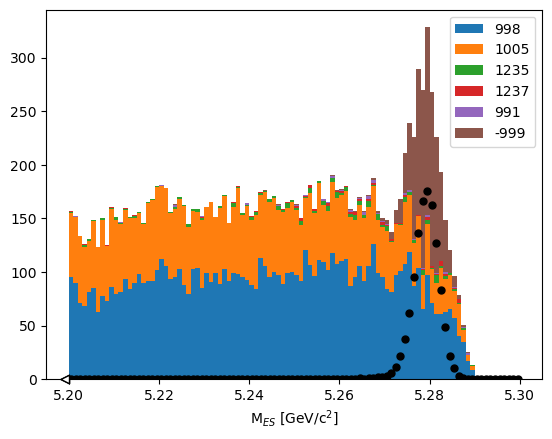

In [4]:
h[:,:,:].stack('SP')[:].project('BpostFitMes').plot(stack=True, histtype="fill")
h[:,['-999'],:].project('BpostFitMes').plot(histtype="errorbar", color='black')

plt.legend()

/home/josieswann/micromamba/envs/pyhep311/lib/python3.11/site-packages/hist/basehist.py:406: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


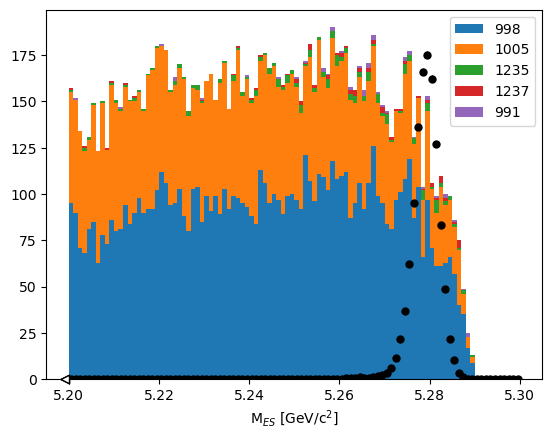

In [5]:
h[:,bkg_spmodes,:].stack('SP')[:].project('BpostFitMes').plot(stack=True, histtype="fill")
h[:,['-999'],:].project('BpostFitMes').plot(histtype="errorbar", color='black')

plt.legend()

# Automate histogram creation

*Not histogram creation*

In [6]:
hist_defs = {}
hist_defs['BSphr'] = {"nbins":100, "lo":0, "hi":0.2, "label":"Sphericity"}


all_hists = {}

for var in hist_defs.keys():
    
    h = Hist.new.Reg(hist_defs[var]["nbins"], hist_defs[var]["lo"], hist_defs[var]["hi"], name=var, label=r"{hist_defs[var][label]}") \
             .StrCat([], name="SP", label="SP modes", growth=True)\
             .StrCat([], name="cuts", label="Cuts", growth=True)\
             .Weight()

    all_hists[var] = h

In [7]:
all_hists

{'BSphr': Hist(
   Regular(100, 0, 0.2, name='BSphr', label='{hist_defs[var][label]}'),
   StrCategory([], growth=True, name='SP', label='SP modes'),
   StrCategory([], growth=True, name='cuts', label='Cuts'),
   storage=Weight()) # Sum: WeightedSum(value=0, variance=0)}

# Automate plotting

In [8]:
#data.fields

In [9]:
h = Hist.new.Reg(100, 0, .2, name="BSphr", label=r"Sphericity") \
         .StrCat([], name="SP", label="SP modes", growth=True)\
         .StrCat([], name="cuts", label="Cuts", growth=True)\
         .Weight()

#for key,value in data.items():
#    x = value['BpostFitMes'][:,0]
#    h.fill(BpostFitMes=x, SP=key, cuts=f"0", weight=1)

spmodes = ['998','1005', '1235', '1237', '3981']
for spmode in spmodes:
    mask = data.spmode == spmode
    x = data[mask]['BSphr'][:,0]
    h.fill(BSphr=x, SP=spmode, cuts=f"0", weight=1)

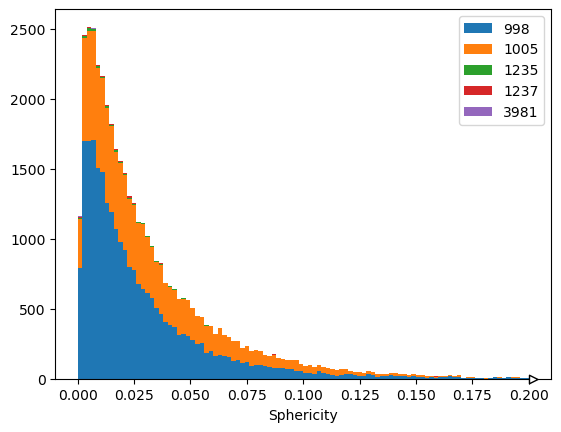

In [10]:
h.stack('SP')[:].project('BSphr').plot(stack=True, histtype="fill")

plt.legend()

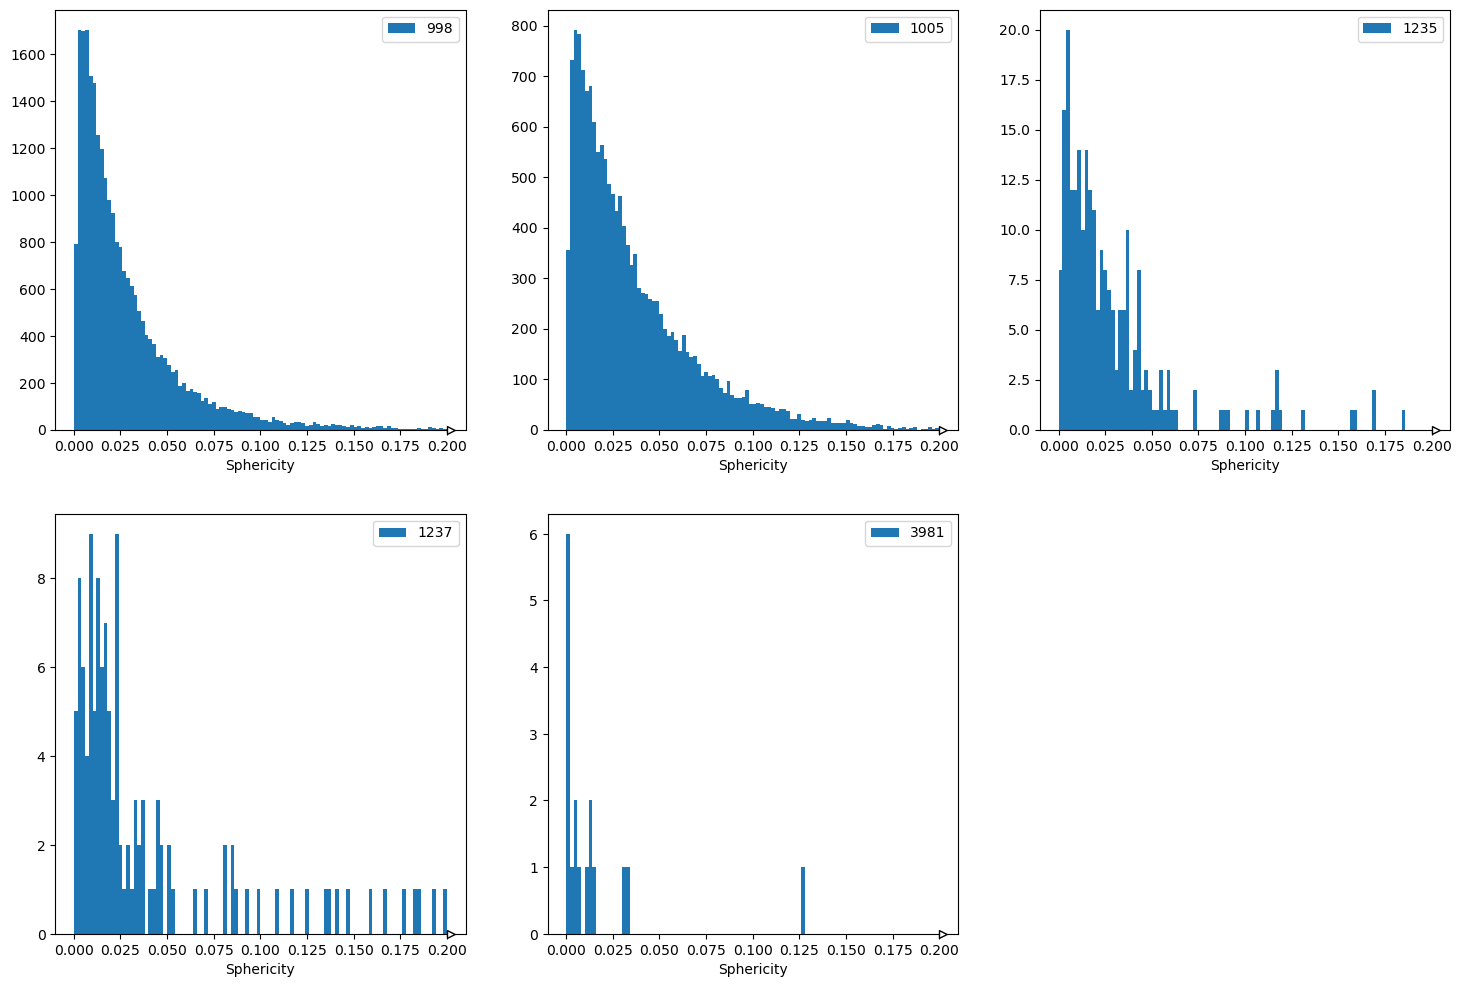

In [11]:
plt.figure(figsize=(18,12))

spmodes = ['998','1005', '1235', '1237', '3981']
for idx,spmode in enumerate(spmodes):
    plt.subplot(2,3,idx+1)
    h[:,spmode,:].project('BSphr').plot(histtype="fill", label=spmode)
    plt.legend()